# Script para búsqueda de puntos de interes médicos

Este script se enfoca en identificar las localizaciones de las farmacias y hospitales en el 2024 a través de información de las encuestas del DENUE 2024.

El objetivo es poder proporcionar localización de farmacias en zonas estratégicas cercanas a los hospitales de la República e inversamente proporcional a donde no hay una cantidad suficiente de farmacias al compararlo con la población a las que, por zonas, corresponden. 

In [46]:
# Importar librerías 
    # Manejo de información en arreglos y dataframes
import numpy as np
import pandas as pd
    # Manejo de información geoespacial
import geopandas as gpd
import pyproj
from shapely.ops import transform
    # Manejo de archivos y directorios del Sistema Operativo
import os
    # Visualizaciones
import matplotlib.pyplot as plt
import seaborn

# Definimos directorios automatizados
CURRENT_PATH = os.getcwd()
GENERAL_PATH = os.path.dirname(CURRENT_PATH)
DATA_PATH = os.path.join(GENERAL_PATH, "data")

## Farmacias 

In [4]:
# Cargar datos sobre actividades económicas: Comercio al por menor enfocado en farmacias
act_eco_path_shp = os.path.join(DATA_PATH, "denue_act_eco_shp\\conjunto_de_datos")

data_farmacias = gpd.read_file(os.path.join(act_eco_path_shp, "denue_inegi_46321-46531_.shp"))
data_farmacias.set_index('id', inplace=True)
data_farmacias.drop(columns=['www', 'correoelec', 'telefono'], inplace=True)
data_farmacias.head(3)

,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,municipio,cve_loc,localidad,ageb,manzana,tipoUniEco,latitud,longitud,fecha_alta,geometry
id,,,,,,,,,,,,,,,,,,,,,
101019,02001463211005221010000000U6,EQUIS TACTICAL,None,463214,"Comercio al por menor de disfraces, vestimenta...",0 a 5 personas,AVENIDA,MEXICO,CALLE,CALIFORNIA,...,Ensenada,0001,Ensenada,7911,018,Fijo,31.852742,-116.591921,2014-12,POINT (-116.59192 31.85274)
112952,02004464111005121000000000U3,EQUILIBRIO FARMACEUTICOS,EQUILIBRIO FARMACEUTICOS,464111,Farmacias sin minisúper,0 a 5 personas,CALLE,LA ESCONDIDA Y/O LAGUNA HANSON,CALLEJON,NINGUNO,...,Tijuana,0001,Tijuana,0579,081,Fijo,32.507295,-116.957871,2014-12,POINT (-116.95787 32.5073)
56435,02002463211005242000000000U0,ESCENA BOUTIQUE,None,463211,"Comercio al por menor de ropa, excepto de bebé...",6 a 10 personas,BOULEVARD,NINGUNO,BOULEVARD,ADOLFO LOPEZ MATEOS,...,Mexicali,0001,Mexicali,4238,035,Fijo,32.659973,-115.480589,2010-07,POINT (-115.48059 32.65997)


In [5]:
data_farmacias[data_farmacias['nombre_act'].str.contains('farmacia', case=False, na=False)]['codigo_act'].value_counts()

codigo_act
464111    53908
464112    11197
Name: count, dtype: int64

In [6]:
data_farmacias.codigo_act = data_farmacias.codigo_act.astype('int64')
data_farmacias = data_farmacias[data_farmacias.codigo_act.isin([464111, 464112])]
data_farmacias.columns

Index(['clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipoCenCom', 'nom_CenCom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'tipoUniEco', 'latitud', 'longitud',
       'fecha_alta', 'geometry'],
      dtype='object')

In [7]:
print(len(data_farmacias.cve_ent.unique()))
# Imprimimos número de farmacias por entidad
data_farmacias[['cve_ent', 'entidad']].value_counts()

32


cve_ent  entidad                        
15       México                             11565
09       Ciudad de México                    6652
14       Jalisco                             4667
30       Veracruz de Ignacio de la Llave     3659
21       Puebla                              3490
16       Michoacán de Ocampo                 3466
11       Guanajuato                          2856
07       Chiapas                             2515
13       Hidalgo                             1987
20       Oaxaca                              1966
02       Baja California                     1782
19       Nuevo León                          1612
25       Sinaloa                             1595
28       Tamaulipas                          1486
08       Chihuahua                           1404
26       Sonora                              1340
12       Guerrero                            1317
22       Querétaro                           1157
05       Coahuila de Zaragoza                1130
17       

In [8]:
# Cuantas sucursales hay de cada empresa farmacéutica
conteo_por_farmacia = data_farmacias['raz_social'].value_counts()
conteo_por_farmacia

raz_social
FARMACIA GUADALAJARA SA DE CV                          2577
FARMACIAS DE SIMILARES SA DE CV                        1884
FARMACON SA DE CV                                      1801
COMERCIALIZADORA FARMACEUTICA DE CHIAPAS SAPI DE CV    1725
FARMACIAS BENAVIDES SA DE CV                           1156
                                                       ... 
FARDEFAM DISTRIBUIDORA                                    1
OLDMO SA DE CV                                            1
DESARROLLO COMERCIAL ALCOCER SA DE CV                     1
DERMO CUTANEA DEL SA DE CV                                1
LINEAS MEDICAS INTERNACIONALES SA DE CV                   1
Name: count, Length: 3343, dtype: int64

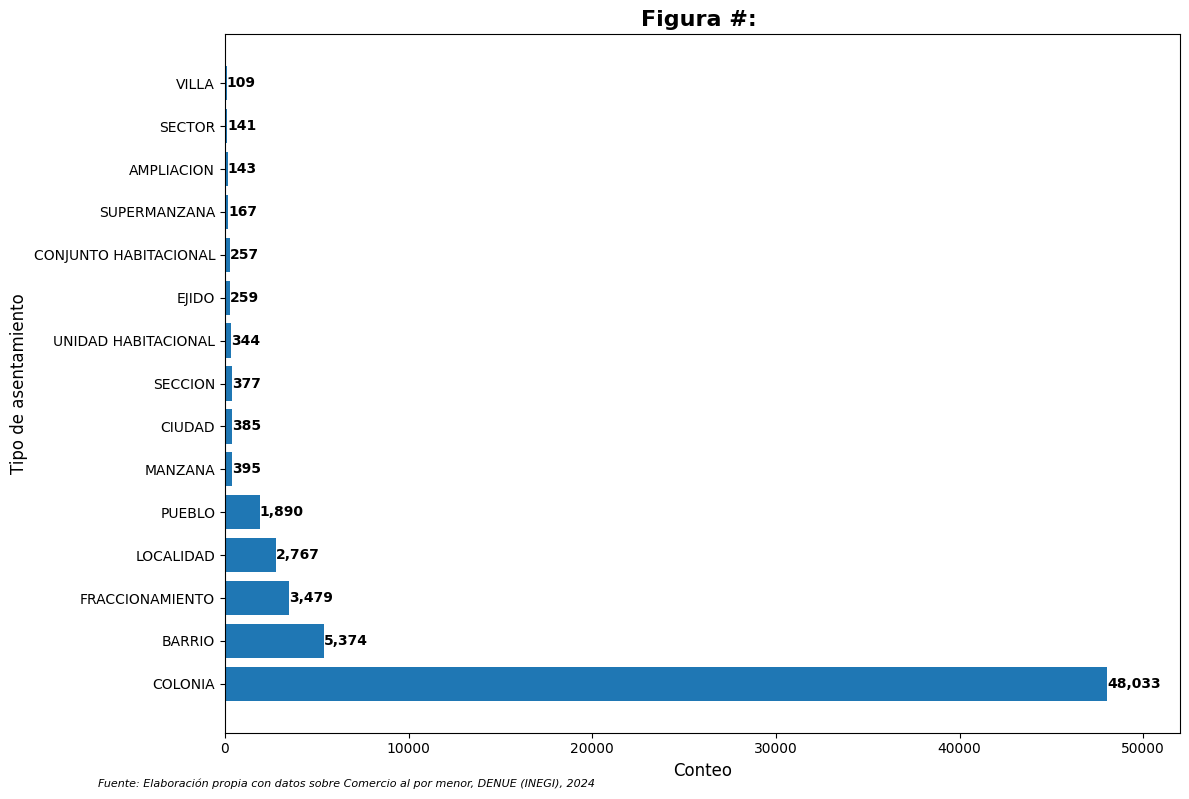

In [9]:
conteo_por_asentamiento = data_farmacias.tipo_asent.value_counts()
# print(conteo_por_asentamiento[:15])

fig, ax = plt.subplots(figsize=(12, 8))

# Barplot
bars = ax.barh(conteo_por_asentamiento[:15].index, conteo_por_asentamiento[:15].values)

ax.set_xlabel("Conteo", fontsize=12)
ax.set_ylabel("Tipo de asentamiento", fontsize=12)
ax.set_title("Figura #: ", fontsize=16, fontweight='bold')
ax.set_xbound([0, 52000])

# Agregar valores a cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:,}', 
            ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()

plt.figtext(0.5, 0.01, "Fuente: Elaboración propia con datos sobre Comercio al por menor, DENUE (INEGI), 2024", 
            ha="right", fontsize=8, style='italic')

plt.show()

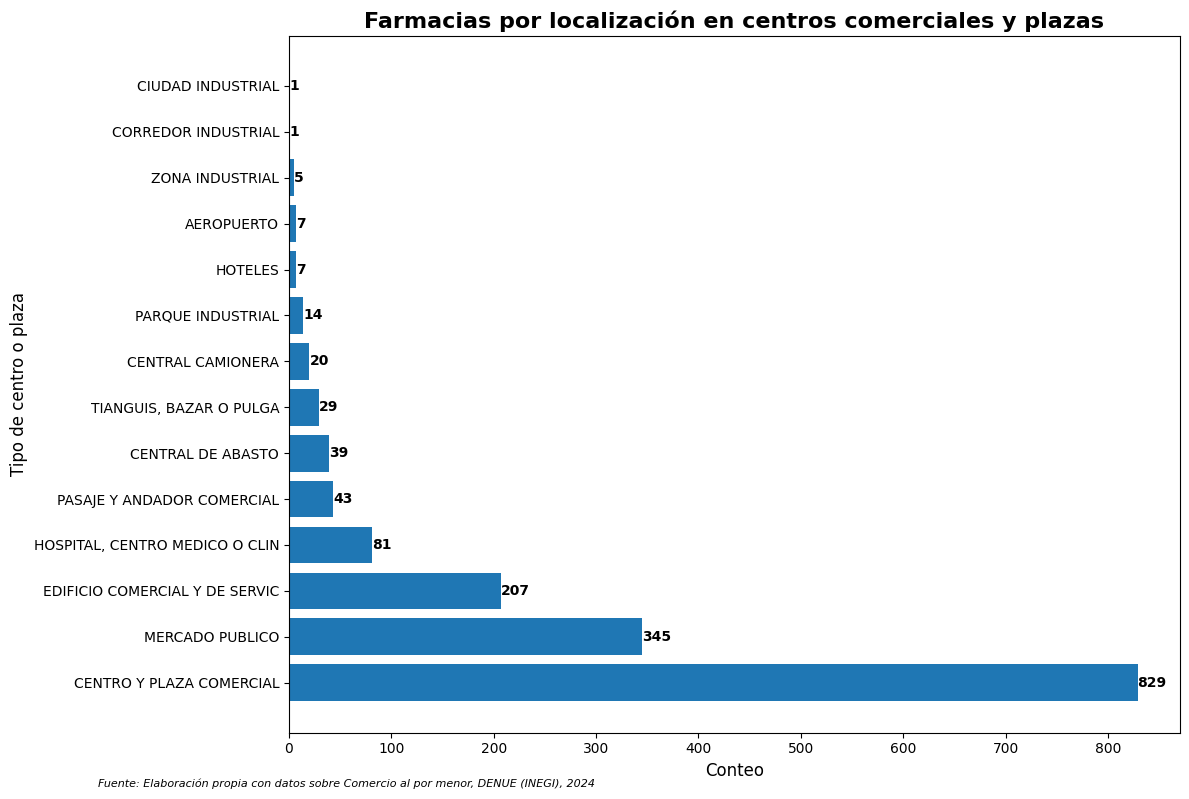

In [221]:
conteo_plaza = data_farmacias.tipoCenCom.value_counts()
# print(conteo_plaza)

fig, ax = plt.subplots(figsize=(12, 8))

# Barplot
bars = ax.barh(conteo_plaza.index, conteo_plaza.values)

ax.set_xlabel("Conteo", fontsize=12)
ax.set_ylabel("Tipo de centro o plaza", fontsize=12)
ax.set_title("Farmacias por localización en centros comerciales y plazas", fontsize=16, fontweight='bold')

# Agregar valores a cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:,}', 
            ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()

plt.figtext(0.5, 0.01, "Fuente: Elaboración propia con datos sobre Comercio al por menor, DENUE (INEGI), 2024", 
            ha="right", fontsize=8, style='italic')

plt.show()

<Axes: xlabel='fecha_alta'>

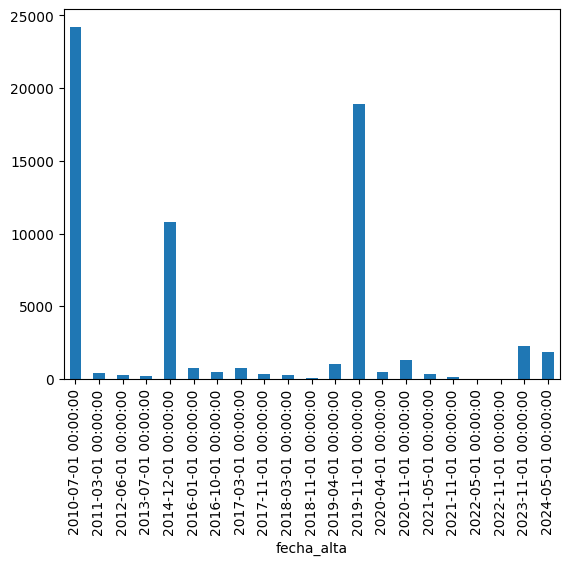

In [11]:
data_farmacias.fecha_alta = data_farmacias.fecha_alta.apply(lambda x: x.replace(' ', '-'))
data_farmacias.fecha_alta = pd.to_datetime(data_farmacias.fecha_alta, format="%Y-%m")
data_farmacias.fecha_alta.sort_values().value_counts(sort=False).plot(kind='bar')

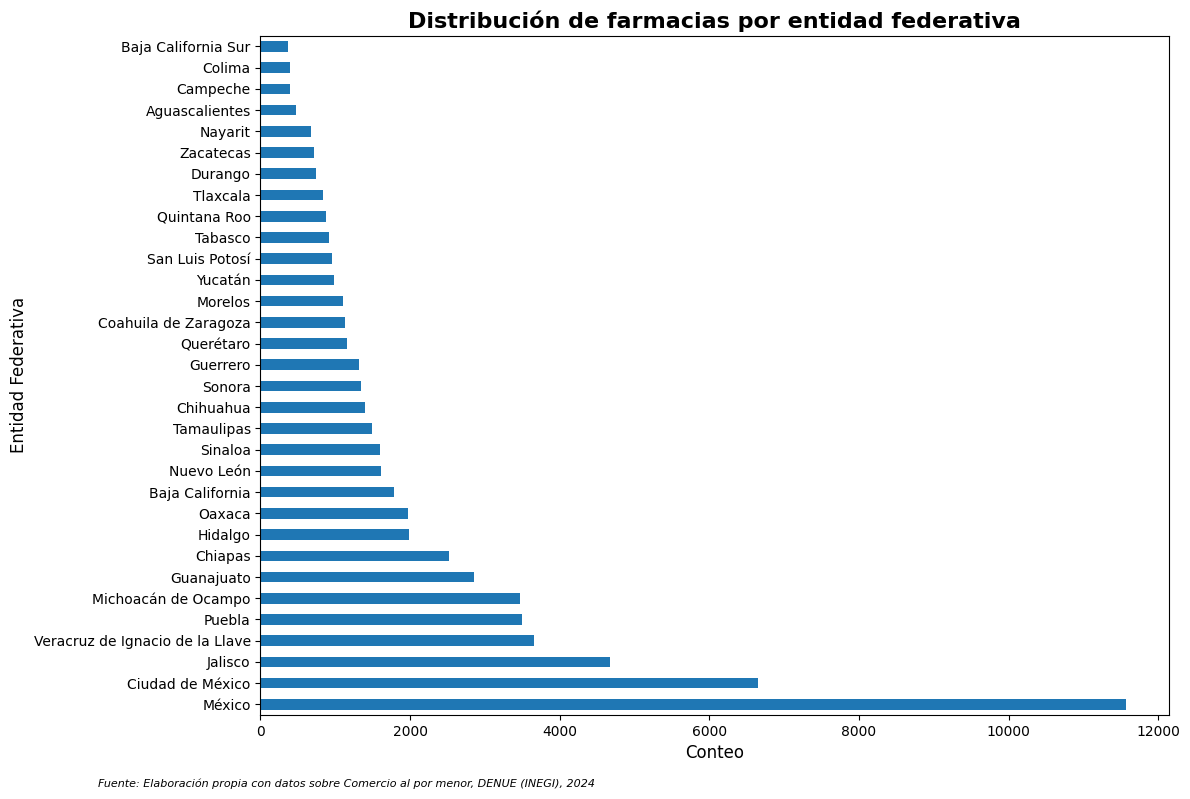

In [222]:
fig, ax = plt.subplots(figsize=(12, 8))

data_farmacias.entidad.value_counts().plot(kind='barh', ax=ax)

ax.set_title("Distribución de farmacias por entidad federativa", fontsize=16, fontweight='bold')
ax.set_xlabel("Conteo", fontsize=12)
ax.set_ylabel("Entidad Federativa", fontsize=12)

plt.figtext(0.5, 0.01, "Fuente: Elaboración propia con datos sobre Comercio al por menor, DENUE (INEGI), 2024", 
            ha="right", fontsize=8, style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

In [13]:
print(len(data_farmacias))
# Es importante conocer el tipo de sistema cartográfico en el que se encuentran nuestros datos
data_farmacias.crs

65105


<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

<Axes: >

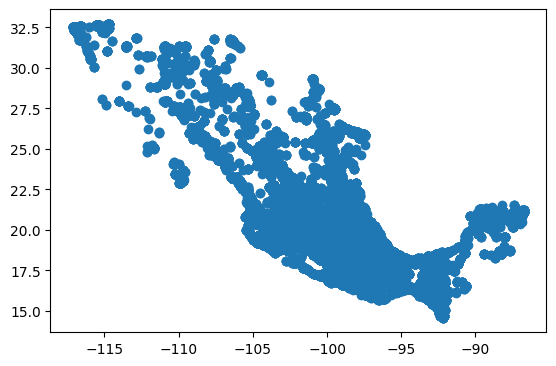

In [14]:
data_farmacias.plot()

In [15]:
# Extraemos un dataset geográfico sobre los estados mexicanos
mexico_path = os.path.join(DATA_PATH, 'Mexico')
mexico = gpd.read_file(os.path.join(mexico_path, 'mexican-states.shp'))
print(mexico.crs)

EPSG:4326


c:\Users\Memit\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\Documentos\ITAM\Dataton\dataton_env\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: c:\Users\Memit\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\Documentos\ITAM\Dataton\Repositorio\Dataton_2024\data\Mexico\mexican-states.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


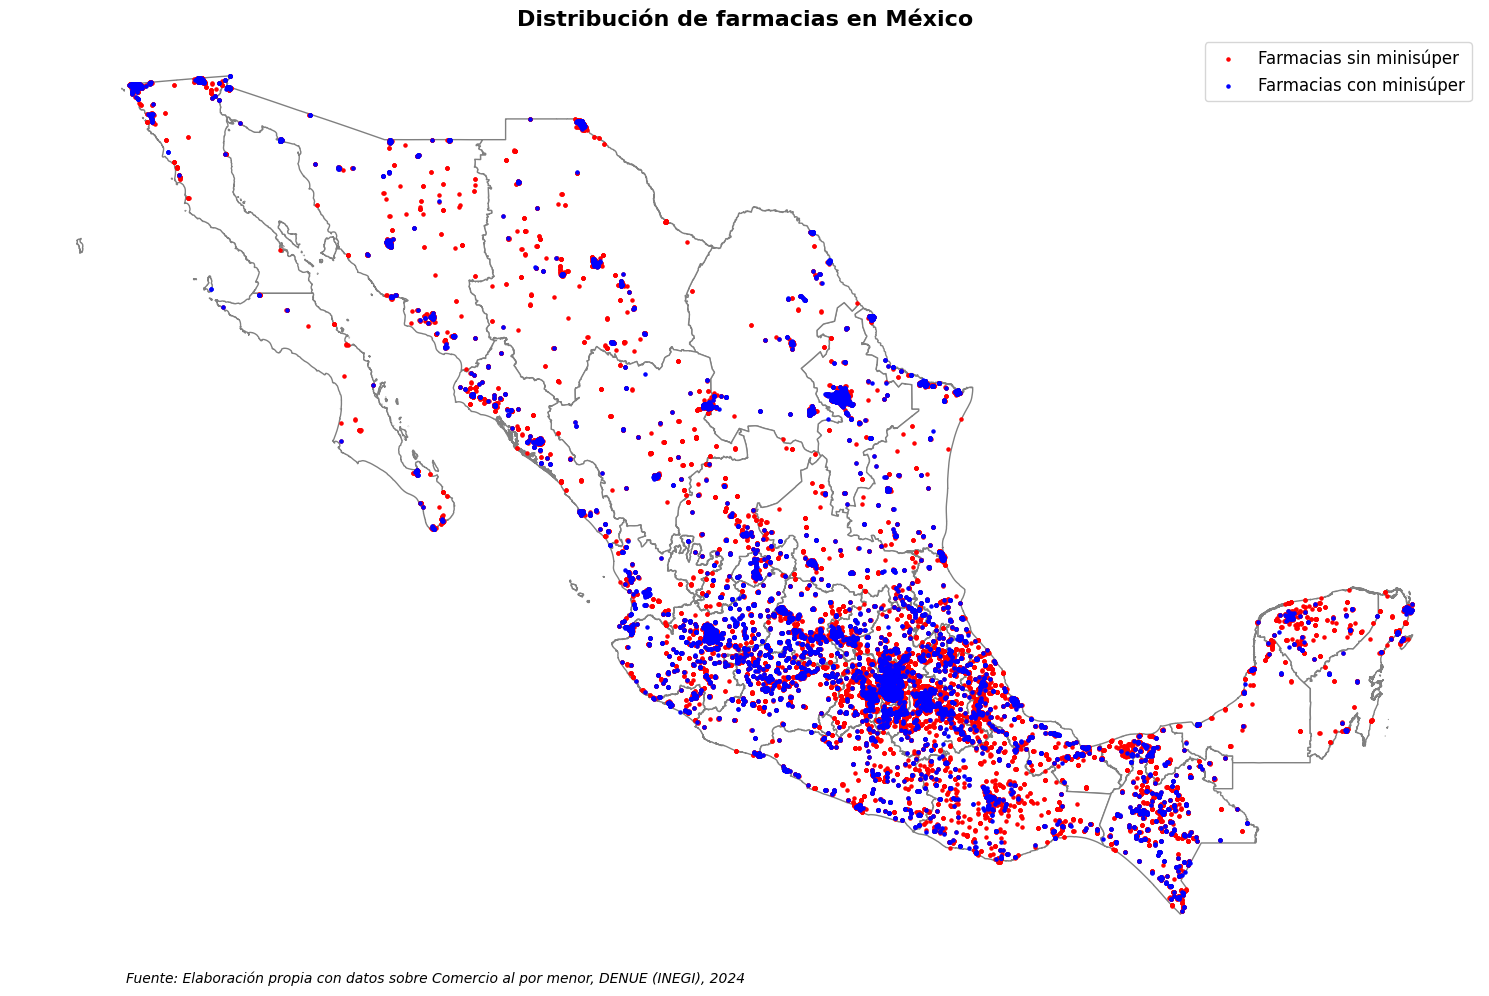

In [225]:
# Visualización para farmacias en méxico según su categoría (cuentan con minisuper o no)
fig, ax = plt.subplots(figsize=(15,10))

    # Primero graficamos la capa de los estados mexicanos
mexico.plot(ax=ax, color = 'white', edgecolor='gray')

    # Guardamos las categorías de farmacias según minisuper o no
mini_super = data_farmacias['nombre_act'].unique()
colors = ['red', 'blue']

# Agregamos cada capa según la categoría a la que pertenecen
for category, color in zip(mini_super, colors):
    subset = data_farmacias[data_farmacias['nombre_act'] == category]
    subset.plot(ax=ax, color=color, markersize=5, label=category)

# data_farmacias.plot(ax=ax, color = 'red', markersize = 5)
ax.set_title("Distribución de farmacias en México", fontsize=16, fontweight='bold')
plt.figtext(0.5, 0.01, "Fuente: Elaboración propia con datos sobre Comercio al por menor, DENUE (INEGI), 2024", 
            ha="right", fontsize=10, style='italic')
ax.set_axis_off()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [17]:
# Cargamos los datos de secciones electorales

seccion_path = os.path.join(DATA_PATH, 'SHAPEFILE')
secciones = gpd.read_file(os.path.join(seccion_path, 'SECCION.shp'))
secciones.set_index('ID', inplace=True)
print(secciones.shape)
secciones.head(3)

(70753, 9)


,ENTIDAD,DISTRITO_F,DISTRITO_L,MUNICIPIO,SECCION,TIPO,CONTROL,GEOMETRY1_,geometry
ID,,,,,,,,,
39365,4,1,7,1,1,2,0.0,None,"POLYGON ((1199620.931 922633.121, 1199518.513 ..."
65994,24,1,2,1,1,2,0.0,None,"POLYGON ((86309.24 1154525.934, 86330.026 1154..."
2105,3,1,10,1,1,2,0.0,None,"POLYGON ((-971912.856 1477780.432, -971478.878..."


In [18]:
# Realizamos la intersección entre los puntos geográficos de las farmacias y los polígonos de las secciones electorales

# Para ello proyectamos el sistema de coordenadas de secciones para coincidir con el de farmacias
secciones = secciones.to_crs(data_farmacias.crs)
seccion_farmacias = gpd.sjoin(data_farmacias, secciones, how="inner", predicate="intersects")
print(seccion_farmacias.shape)
seccion_farmacias.head(3)

(65082, 48)


,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,geometry,ID,ENTIDAD,DISTRITO_F,DISTRITO_L,MUNICIPIO,SECCION,TIPO,CONTROL,GEOMETRY1_
id,,,,,,,,,,,,,,,,,,,,,
112952,02004464111005121000000000U3,EQUILIBRIO FARMACEUTICOS,EQUILIBRIO FARMACEUTICOS,464111,Farmacias sin minisúper,0 a 5 personas,CALLE,LA ESCONDIDA Y/O LAGUNA HANSON,CALLEJON,NINGUNO,...,POINT (-116.95787 32.5073),1093,2,5,9,4,1117,2,0.0,None
6734444,02004464111006271001000000S5,EQUILIBRIO FARMACEUTICO,EQUILIBRIO FARMACEUTICO SA DE CV,464111,Farmacias sin minisúper,6 a 10 personas,CALLE,ALAMO,CALLE,VIA RAPIDA ORIENTE,...,POINT (-116.95409 32.50509),1113,2,5,9,4,1138,2,0.0,None
72225,02002464111000321000000000U8,FARMACIA Y PAPELERÍA SAN PEDRO,None,464111,Farmacias sin minisúper,0 a 5 personas,CALZADA,LICENCIADO VICENTE LOMBARDO TOLEDANO,AVENIDA,TOLEDO,...,POINT (-115.47254 32.6138),334,2,2,3,2,342,2,0.0,None


Estamos perdiendo 65105-65082=23 (hay 23 puntos que no caen en ningun poligono), investigando un poco sobre estos datos nos damos cuenta que todos son localizaciones costeras, por lo que creemos puede haber ligeras asimetrías geográficas. 

In [19]:
seccion_farmacias[['cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ENTIDAD', 'MUNICIPIO', 'DISTRITO_L']]

,cve_ent,entidad,cve_mun,municipio,cve_loc,localidad,ENTIDAD,MUNICIPIO,DISTRITO_L
id,,,,,,,,,
112952,02,Baja California,004,Tijuana,0001,Tijuana,2,4,9
6734444,02,Baja California,004,Tijuana,0001,Tijuana,2,4,9
72225,02,Baja California,002,Mexicali,0001,Mexicali,2,2,3
6424346,02,Baja California,001,Ensenada,0124,Isla de Cedros,2,1,17
136476,02,Baja California,002,Mexicali,0001,Mexicali,2,2,2
...,...,...,...,...,...,...,...,...,...
7455217,32,Zacatecas,039,Río Grande,0001,Río Grande,32,39,17
8904199,32,Zacatecas,039,Río Grande,0001,Río Grande,32,39,17
8378158,31,Yucatán,096,Tizimín,0034,Popolnáh,31,96,17


En este comando buscamos intersectar las localizaciones de puntos geográficos de las farmacias, con los polígonos de secciones electorales, para identificar a que secciones corresponden. 

- **intersects**: Devuelve True si el límite o el interior del objeto se interseca de alguna manera con los del otro. En otras palabras, los objetos geométricos se intersecan si tienen algún punto límite o interior en común.

In [20]:
# Prueba para verificar cuales son las 23 farmacias faltantes
prueba = gpd.sjoin(data_farmacias, secciones.to_crs(data_farmacias.crs), how="left", predicate="intersects")
print(len(data_farmacias))
print(len(prueba))
prueba[prueba.ID.isna()][['entidad', 'municipio']]

65105
65105


,entidad,municipio
id,,
7089880,Baja California Sur,Los Cabos
3617880,Quintana Roo,Solidaridad
7877026,Quintana Roo,Solidaridad
3619895,Quintana Roo,Solidaridad
3664623,Quintana Roo,Benito Juárez
8915305,Quintana Roo,Solidaridad
7878990,Quintana Roo,Solidaridad
8720642,Quintana Roo,Solidaridad
6762675,Quintana Roo,Solidaridad


In [21]:
# Verificamos a que razon social pertenecen
index_og = set(data_farmacias.index)
index_res = set(seccion_farmacias.index)
diff = index_og - index_res
data_farmacias.loc[list(diff)]['raz_social'].value_counts(dropna = False)

raz_social
None                              17
DROUGSTORE XPRESS SA DE CV         1
PHARMA PLAYA DRUSTORE SA DE CV     1
DRUGSTORE XPRESS SA DE CV          1
PHARMA PLAYA SA DE CV              1
GFLOFEX SAPI DE CV                 1
ROXANAS DEL CARIBE SA DE CV        1
Name: count, dtype: int64

In [22]:
farm_faltantes = data_farmacias.loc[list(diff)]

# Notese que el parámetro max_distance corresponde en las unidades del CRS correspondiente (grados)
sec_farm_cerca = gpd.sjoin_nearest(farm_faltantes, secciones, how="inner", max_distance=1,
                                distance_col='distance')

print(len(data_farmacias.loc[list(diff)]))
print(len(sec_farm_cerca))

print(f"Distancia promedio a la sección más cercana: {sec_farm_cerca['distance'].mean()} grados")
print(f"Distancia promedio a la sección más cercana: {sec_farm_cerca['distance'].mean()*111.32*1000} metros")

# Tiramos la columna de distancia ya que ya no nos aporta información
sec_farm_cerca.drop(columns={'distance'}, inplace=True)

sec_farm_cerca[['cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ENTIDAD', 'MUNICIPIO', 'DISTRITO_L', 'SECCION']]

23
23
Distancia promedio a la sección más cercana: 0.0005292201458451082 grados
Distancia promedio a la sección más cercana: 58.91278663547744 metros


c:\Users\Memit\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\Documentos\ITAM\Dataton\dataton_env\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,cve_ent,entidad,cve_mun,municipio,cve_loc,localidad,ENTIDAD,MUNICIPIO,DISTRITO_L,SECCION
id,,,,,,,,,,
8720642,23,Quintana Roo,008,Solidaridad,0001,Playa del Carmen,23,8,10,922
3884953,26,Sonora,048,Puerto Peñasco,0001,Puerto Peñasco,26,53,2,647
7906721,23,Quintana Roo,008,Solidaridad,0001,Playa del Carmen,23,8,11,763
7877026,23,Quintana Roo,008,Solidaridad,0001,Playa del Carmen,23,8,10,206
3884967,26,Sonora,048,Puerto Peñasco,0001,Puerto Peñasco,26,53,2,647
7909674,26,Sonora,048,Puerto Peñasco,0001,Puerto Peñasco,26,53,2,647
8263855,26,Sonora,048,Puerto Peñasco,0001,Puerto Peñasco,26,53,2,647
7833519,23,Quintana Roo,008,Solidaridad,0001,Playa del Carmen,23,8,10,206
8263858,26,Sonora,048,Puerto Peñasco,0001,Puerto Peñasco,26,53,2,647


In [23]:
# Reconstruimos nuestro conjunto de datos original al concatenar ambos conjuntos 
    # Notese que son conjuntos disjuntos y por ende no habrá duplicados
seccion_farmacias_completo = pd.concat([seccion_farmacias, sec_farm_cerca], axis=0)
print("Conteo de farmacias (top 200)")
conteo_farm = seccion_farmacias_completo.SECCION.value_counts()
print(conteo_farm[:200])

Conteo de farmacias (top 200)
SECCION
868     87
316     80
459     74
1192    74
2       72
        ..
141     35
135     35
1351    35
27      35
1603    35
Name: count, Length: 200, dtype: int64


In [24]:
print("Conteo de farmacias (top 200 más bajo)")
print(conteo_farm[-200:])

Conteo de farmacias (top 200 más bajo)
SECCION
6066    1
5924    1
4783    1
6901    1
6128    1
       ..
6306    1
4971    1
4969    1
4098    1
4064    1
Name: count, Length: 200, dtype: int64


## Hospitales

In [25]:
# Cargar datos sobre actividades económicas: Comercio al por menor enfocado en farmacias
hospitales_path = os.path.join(DATA_PATH, "denue_hospitales_shp\\conjunto_de_datos")

data_hospitales = gpd.read_file(os.path.join(hospitales_path, "denue_inegi_62_.shp"))
data_hospitales.set_index('id', inplace=True)
data_hospitales.drop(columns=['www', 'correoelec', 'telefono'], inplace=True)
data_hospitales.head(3)

,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,municipio,cve_loc,localidad,ageb,manzana,tipoUniEco,latitud,longitud,fecha_alta,geometry
id,,,,,,,,,,,,,,,,,,,,,
101363,02001621211002581000000000U5,DENTISTA MILITAR,None,621211,Consultorios dentales del sector privado,0 a 5 personas,CALLE,RIO BLANCO,CALLE,AMAZONAS,...,Ensenada,0001,Ensenada,7964,044,Fijo,31.845642,-116.601959,2014-12,POINT (-116.60196 31.84564)
69228,02004621211002811000000000U0,DENTISTA LOMELI,None,621211,Consultorios dentales del sector privado,0 a 5 personas,AVENIDA,BUCARELI,CALLE,CHICAGO,...,Tijuana,0001,Tijuana,0598,007,Fijo,32.489294,-117.041228,2010-07,POINT (-117.04123 32.48929)
7049128,02004621211016431000000000U1,DENTISTA OASIS,None,621211,Consultorios dentales del sector privado,0 a 5 personas,BOULEVARD,REAL DE BAJA CALIFORNIA,BOULEVARD,REAL DE LAS LOMAS,...,Tijuana,0001,Tijuana,728A,006,Fijo,32.486737,-116.848466,2019-11,POINT (-116.84847 32.48674)


In [26]:
data_hospitales[data_hospitales['nombre_act'].str.contains('hospital', case=False, na=False)]['codigo_act'].value_counts()

codigo_act
622112    2624
622111    2007
622311     915
621491     472
622312     159
622211      70
622212      42
621492      41
Name: count, dtype: int64

In [27]:
data_hospitales[data_hospitales['codigo_act'].str.contains('621') & data_hospitales['nombre_act'].str.contains('hospital', case=False, na=False)]['nombre_act'].unique()

array(['Otros centros del sector privado para la atención de pacientes que no requieren hospitalización',
       'Otros centros del sector público para la atención de pacientes que no requieren hospitalización'],
      dtype=object)

In [28]:
cod_list = data_hospitales[data_hospitales['nombre_act'].str.contains('hospital', case=False, na=False)]['codigo_act'].unique()
print(f"Servicios de salud original: {len(data_hospitales)}")
data_hospitales = data_hospitales[data_hospitales.codigo_act.isin(cod_list) & ~data_hospitales['codigo_act'].astype('int64').isin([621491, 621492])]
print(f"Hospitales filtrada: {len(data_hospitales)}")

Servicios de salud original: 235222
Hospitales filtrada: 5817


In [29]:
print(len(data_hospitales.cve_ent.unique()))
# Imprimimos número de hospitales por entidad
data_hospitales[['cve_ent', 'entidad']].value_counts()

32


cve_ent  entidad                        
15       México                             485
14       Jalisco                            416
09       Ciudad de México                   402
19       Nuevo León                         340
30       Veracruz de Ignacio de la Llave    338
20       Oaxaca                             303
21       Puebla                             285
11       Guanajuato                         273
16       Michoacán de Ocampo                259
07       Chiapas                            236
02       Baja California                    221
08       Chihuahua                          194
28       Tamaulipas                         187
26       Sonora                             165
05       Coahuila de Zaragoza               162
25       Sinaloa                            153
12       Guerrero                           151
22       Querétaro                          126
31       Yucatán                            124
13       Hidalgo                            118

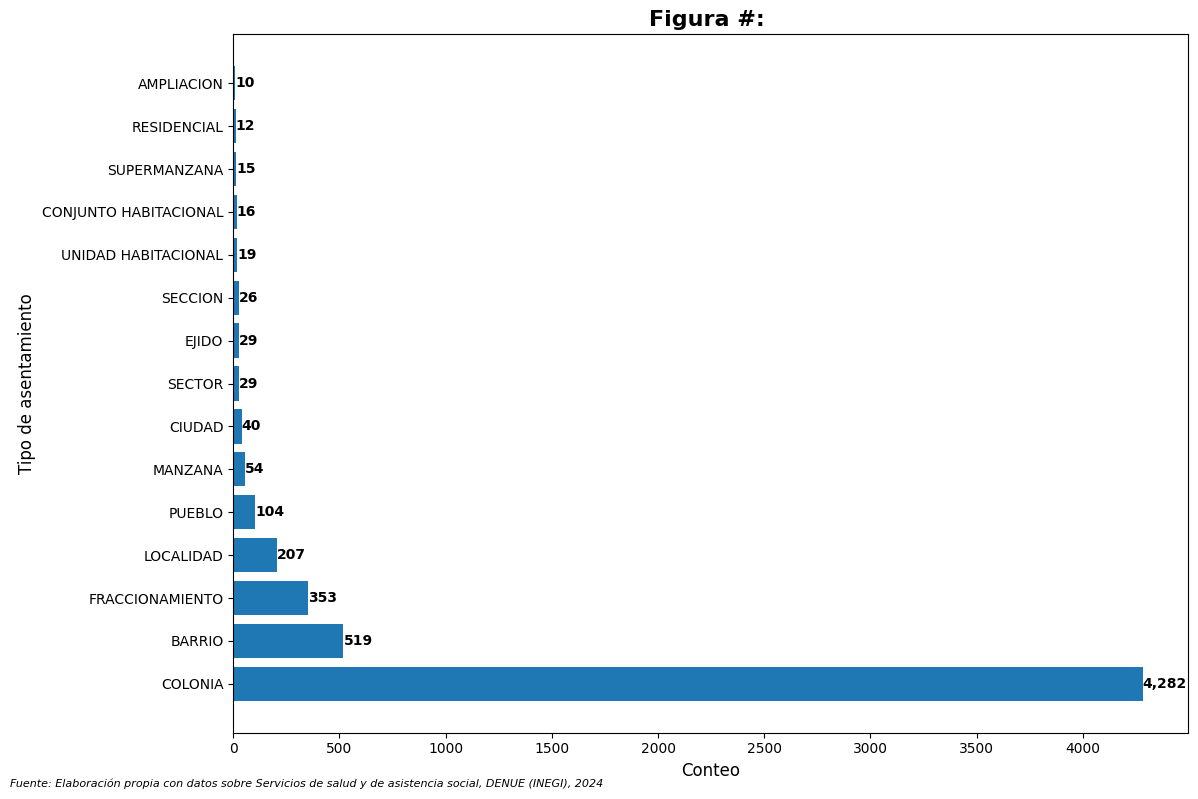

In [30]:
hospitales_por_asentamiento = data_hospitales.tipo_asent.value_counts()
# print(hospitales_por_asentamiento[:15])

fig, ax = plt.subplots(figsize=(12, 8))

# Barplot
bars = ax.barh(hospitales_por_asentamiento[:15].index, hospitales_por_asentamiento[:15].values)

ax.set_xlabel("Conteo", fontsize=12)
ax.set_ylabel("Tipo de asentamiento", fontsize=12)
ax.set_title("Figura #: ", fontsize=16, fontweight='bold')

# Agregar valores a cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:,}', 
            ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()

plt.figtext(0.5, 0.01, "Fuente: Elaboración propia con datos sobre Servicios de salud y de asistencia social, DENUE (INEGI), 2024", 
            ha="right", fontsize=8, style='italic')

plt.show()

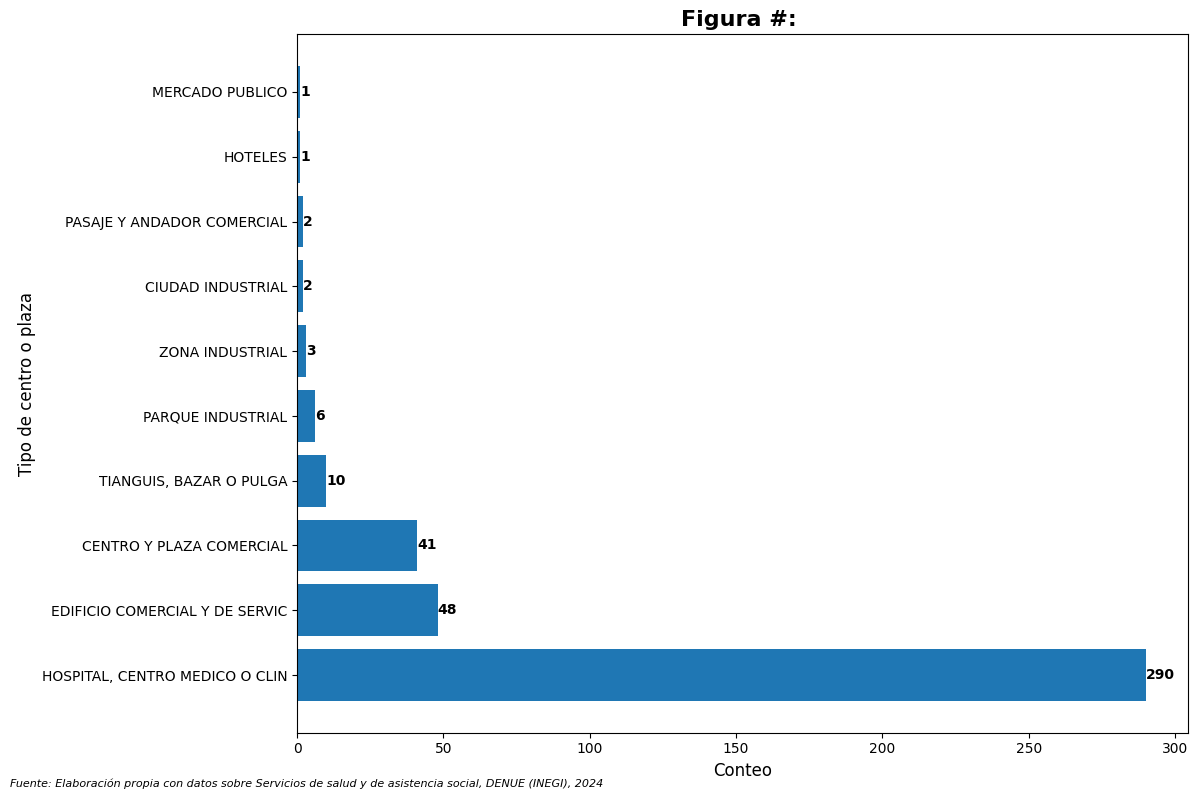

In [31]:
hosp_plaza = data_hospitales.tipoCenCom.value_counts()
# print(hosp_plaza)

fig, ax = plt.subplots(figsize=(12, 8))

# Barplot
bars = ax.barh(hosp_plaza.index, hosp_plaza.values)

ax.set_xlabel("Conteo", fontsize=12)
ax.set_ylabel("Tipo de centro o plaza", fontsize=12)
ax.set_title("Figura #: ", fontsize=16, fontweight='bold')

# Agregar valores a cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:,}', 
            ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()

plt.figtext(0.5, 0.01, "Fuente: Elaboración propia con datos sobre Servicios de salud y de asistencia social, DENUE (INEGI), 2024", 
            ha="right", fontsize=8, style='italic')

plt.show()

<Axes: xlabel='fecha_alta'>

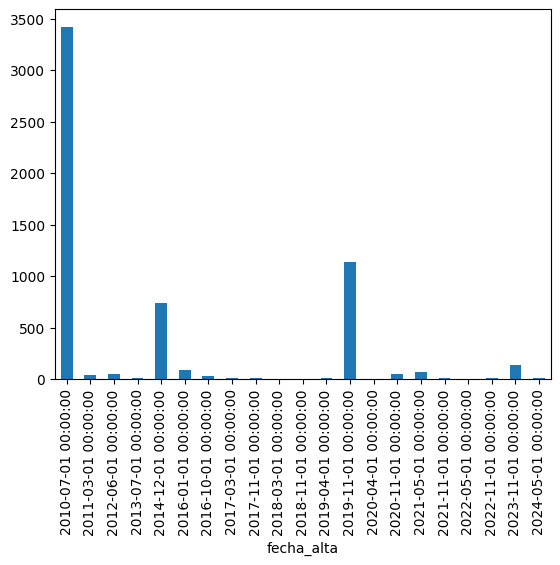

In [32]:
data_hospitales.fecha_alta = data_hospitales.fecha_alta.apply(lambda x: x.replace(' ', '-'))
data_hospitales.fecha_alta = pd.to_datetime(data_hospitales.fecha_alta, format="%Y-%m")
data_hospitales.fecha_alta.sort_values().value_counts(sort=False).plot(kind='bar')

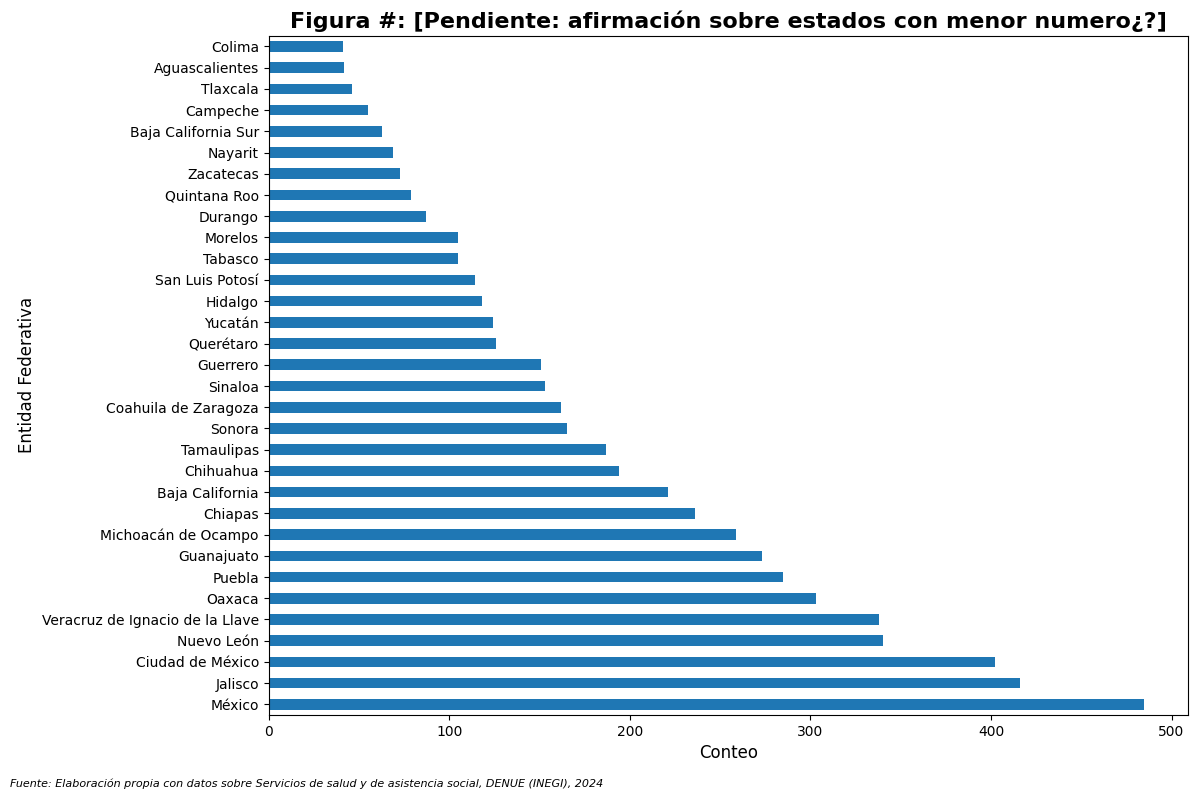

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

data_hospitales.entidad.value_counts().plot(kind='barh', ax=ax)

ax.set_title("Figura #: [Pendiente: afirmación sobre estados con menor numero¿?]", fontsize=16, fontweight='bold')
ax.set_xlabel("Conteo", fontsize=12)
ax.set_ylabel("Entidad Federativa", fontsize=12)

plt.figtext(0.5, 0.01, "Fuente: Elaboración propia con datos sobre Servicios de salud y de asistencia social, DENUE (INEGI), 2024", 
            ha="right", fontsize=8, style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

<Axes: >

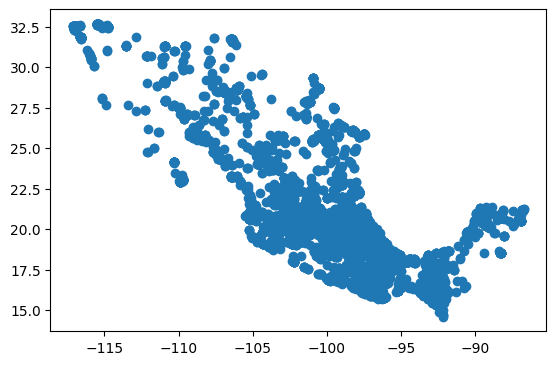

In [34]:
data_hospitales.plot()

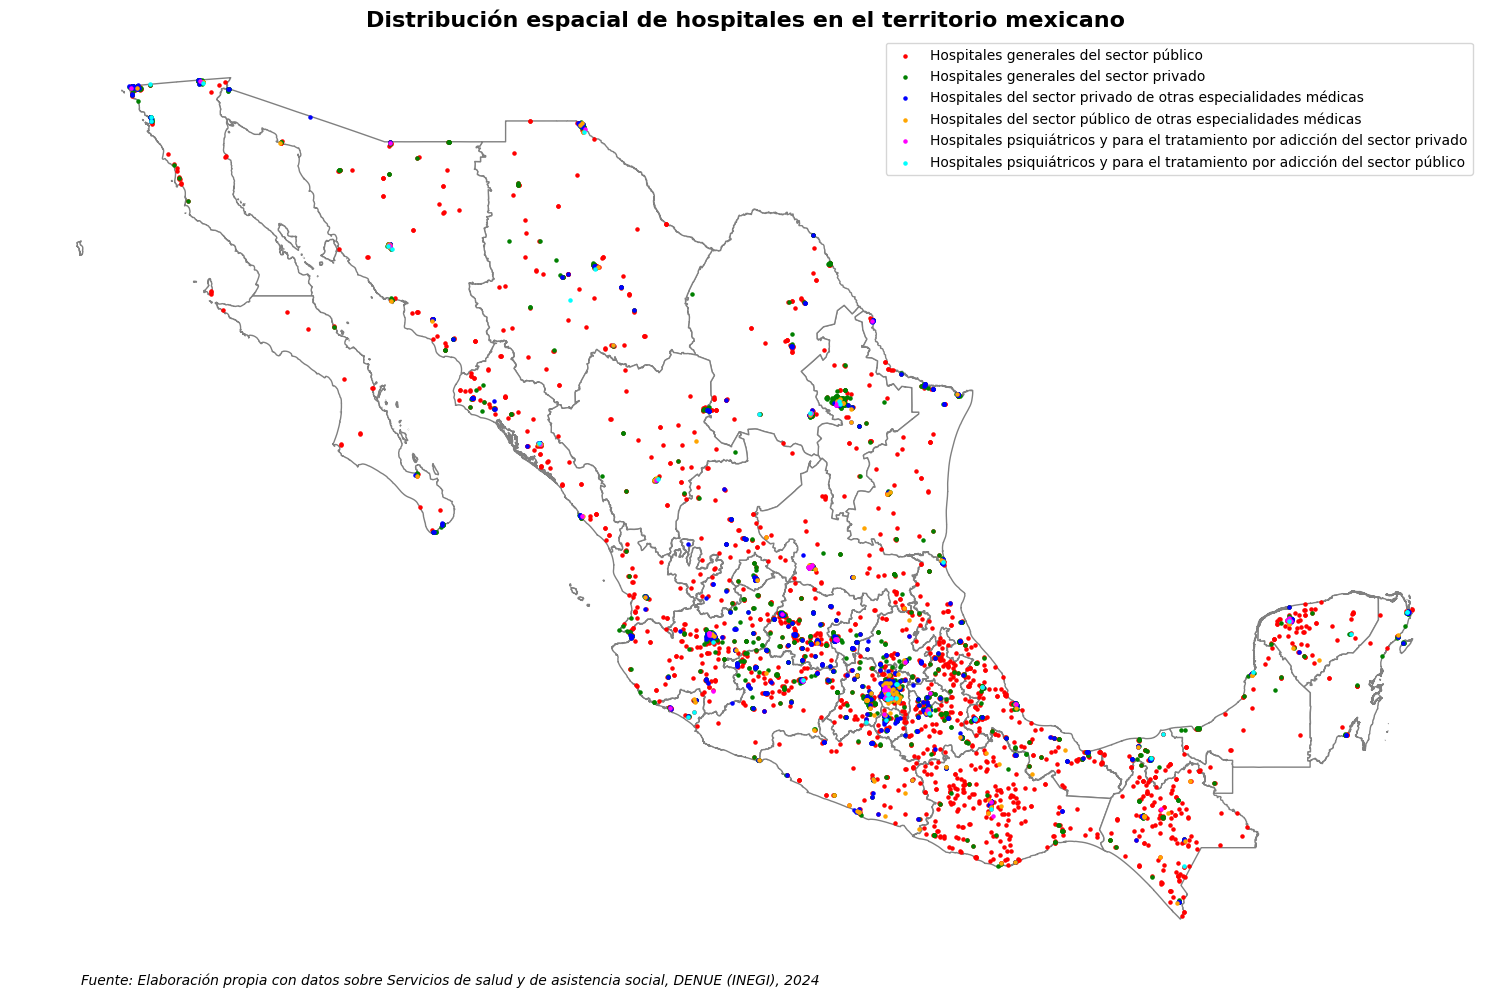

In [224]:
fig, ax = plt.subplots(figsize=(15,10))
mexico.plot(ax=ax, color = 'white', edgecolor='gray')
# secciones.to_crs(data_hospitales.crs).plot(ax=ax, color = 'white')

tipo_hospitales = data_hospitales['nombre_act'].unique()
colors = ['red', 'green', 'blue', 'orange', 'magenta', 'cyan']

for category, color in zip(tipo_hospitales, colors):
    subset = data_hospitales[data_hospitales['nombre_act'] == category]
    subset.plot(ax=ax, color=color, markersize=5, label=category)

ax.set_title("Distribución espacial de hospitales en el territorio mexicano", fontsize=16, fontweight='bold')
plt.figtext(0.55, 0.01, "Fuente: Elaboración propia con datos sobre Servicios de salud y de asistencia social, DENUE (INEGI), 2024", 
            ha="right", fontsize=10, style='italic')
ax.set_axis_off()
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
data_hospitales['nombre_act'].unique()

array(['Hospitales generales del sector público',
       'Hospitales generales del sector privado',
       'Hospitales del sector privado de otras especialidades médicas',
       'Hospitales del sector público de otras especialidades médicas',
       'Hospitales psiquiátricos y para el tratamiento por adicción del sector privado',
       'Hospitales psiquiátricos y para el tratamiento por adicción del sector público'],
      dtype=object)

In [37]:
# Agrupemos en tres categorías: hospitales generales públicos y privados
    # y hospitales especializados publicos y privados
def categorias_hospitales(x):
    if 'psiquiátricos' in x:
        if 'privado' in x:
            return 'Hospitales del sector privado de otras especialidades médicas'
        else:
            return 'Hospitales del sector público de otras especialidades médicas'
    else:
        return x
    
data_hospitales['categoria'] = data_hospitales['nombre_act'].apply(categorias_hospitales)
data_hospitales['categoria'].unique()

array(['Hospitales generales del sector público',
       'Hospitales generales del sector privado',
       'Hospitales del sector privado de otras especialidades médicas',
       'Hospitales del sector público de otras especialidades médicas'],
      dtype=object)

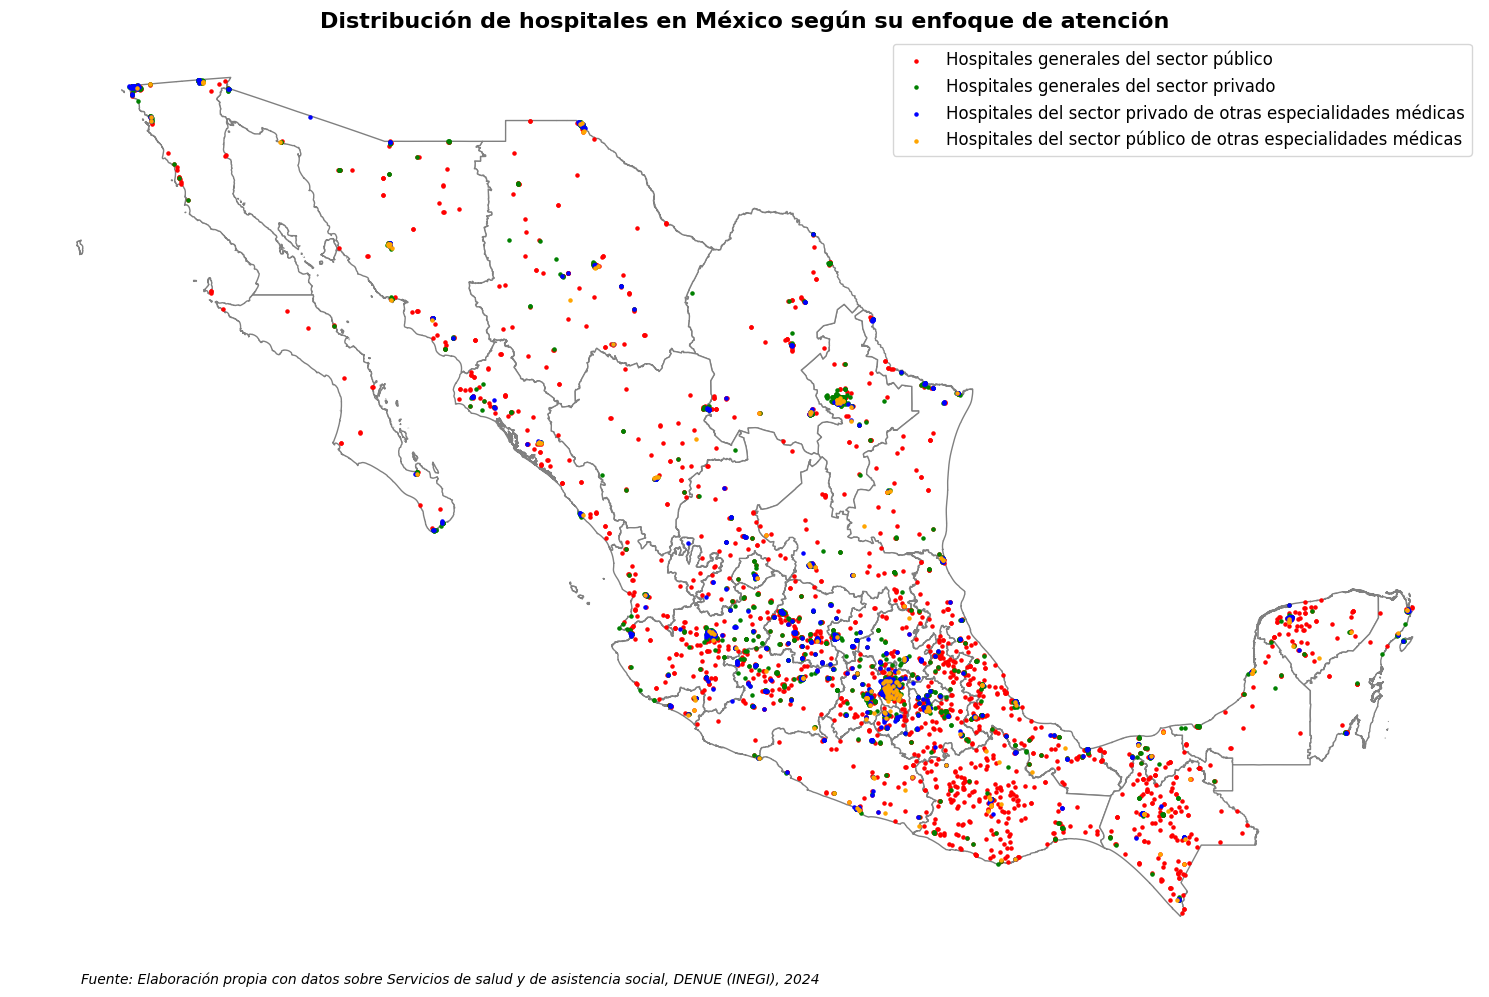

In [227]:

fig, ax = plt.subplots(figsize=(15,10))
mexico.plot(ax=ax, color = 'white', edgecolor='gray')

tipo_hospitales = data_hospitales['categoria'].unique()
colors = ['red', 'green', 'blue', 'orange']

for category, color in zip(tipo_hospitales, colors):
    subset = data_hospitales[data_hospitales['categoria'] == category]
    subset.plot(ax=ax, color=color, markersize=5, label=category)

ax.set_title("Distribución de hospitales en México según su enfoque de atención", fontsize=16, fontweight='bold')
plt.figtext(0.55, 0.01, "Fuente: Elaboración propia con datos sobre Servicios de salud y de asistencia social, DENUE (INEGI), 2024", 
            ha="right", fontsize=10, style='italic')
ax.set_axis_off()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [39]:
seccion_hospitales = gpd.sjoin(data_hospitales, secciones, how="inner", predicate="intersects")
print(data_hospitales.shape)
print(seccion_hospitales.shape)
seccion_hospitales.head(3)

(5817, 40)
(5816, 49)


,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,categoria,ID,ENTIDAD,DISTRITO_F,DISTRITO_L,MUNICIPIO,SECCION,TIPO,CONTROL,GEOMETRY1_
id,,,,,,,,,,,,,,,,,,,,,
58542,02002622112000387000000000U6,HOSPITAL GENERAL 5 DE DICIEMBRE,None,622112,Hospitales generales del sector público,251 y más personas,AVENIDA,AVENIDA DE LA LIBERTAD,CALLE,CALLE DEL HOSPITAL,...,Hospitales generales del sector público,256,2,2,3,2,264,2,0.0,None
141454,02005622112000076001000000U8,HOSPITAL GENERAL DE PLAYAS DE ROSARITO,INSTITUTO DE SERVICIOS DE SALUD PUBLICA DEL ES...,622112,Hospitales generales del sector público,251 y más personas,CALLE,GALILEA,CARRETERA,DE CUOTA A ENSENADA,...,Hospitales generales del sector público,1317,2,9,15,5,1365,2,0.0,None
151002,02001622112000153000000000U4,HOSPITAL GENERAL DE SUB ZONA MEDICINA FAMILIAR 13,INSTITUTO MEXICANO DEL SEGURO SOCIAL,622112,Hospitales generales del sector público,11 a 30 personas,CALLE,NINGUNO,CALLE,NINGUNO,...,Hospitales generales del sector público,159,2,3,17,1,165,2,0.0,None


Estamos perdiendo 1 solo dato, su localización también está en la costa

In [40]:
sec_hosp_cerca = gpd.sjoin_nearest(data_hospitales.loc[list(set(data_hospitales.index)-set(seccion_hospitales.index))], secciones, how="inner", max_distance=1,
                                distance_col='distance')
sec_hosp_cerca[['cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ENTIDAD', 'MUNICIPIO', 'DISTRITO_L', 'SECCION']]

c:\Users\Memit\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\Documentos\ITAM\Dataton\dataton_env\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,cve_ent,entidad,cve_mun,municipio,cve_loc,localidad,ENTIDAD,MUNICIPIO,DISTRITO_L,SECCION
id,,,,,,,,,,
8718323,18,Nayarit,020,Bahía de Banderas,0236,Desarrollo Punta Mita,18,4,16,110


In [41]:
seccion_hospitales_completo = pd.concat([seccion_hospitales, sec_hosp_cerca], axis = 0)
print("Conteo de hospitales (top 200)")
conteo_hosp = seccion_hospitales_completo.SECCION.value_counts()
print(conteo_hosp[:200])

Conteo de hospitales (top 200)
SECCION
437     31
1116    21
1117    20
220     18
881     18
        ..
186      5
787      5
1511     5
30       5
1242     5
Name: count, Length: 200, dtype: int64


In [42]:
print("Conteo de hospitales (top 200 más bajo)")
print(conteo_hosp[-200:])

Conteo de hospitales (top 200 más bajo)
SECCION
1429    1
997     1
1388    1
1060    1
825     1
       ..
3748    1
4930    1
3712    1
1625    1
4978    1
Name: count, Length: 200, dtype: int64


## Creación de buffer para encontrar hospitales sin farmacias en un radio de 1 Km

In [278]:
buff_hospitales = seccion_hospitales_completo.copy()

buff_hospitales = buff_hospitales.to_crs("EPSG:4326")

# Project to a local UTM zone for accurate distance measurements
buff_hospitales = buff_hospitales.to_crs(buff_hospitales.estimate_utm_crs())

# Create a 1 km buffer
buff_hospitales['geometry'] = buff_hospitales['geometry'].buffer(1000)

# Project back to the original coordinate system
buff_hospitales = buff_hospitales.to_crs("EPSG:4326")

In [279]:
print(buff_hospitales.crs)
buff_hospitales.geometry.area.mean()

EPSG:4326


C:\Users\Memit\AppData\Local\Temp\ipykernel_16896\909392117.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buff_hospitales.geometry.area.mean()


np.float64(0.0002723762994392453)

In [280]:
# Ajustamos ambos sistemas de medición
buff_hospitales = buff_hospitales.to_crs(data_farmacias.crs)

# Buscamos unir los datasets según aquellas farmacias que caigan dentro de los polígonos (buffer de hospitales)
farm_per_hosp = gpd.sjoin(data_farmacias, buff_hospitales, how='inner', predicate='within')
print(len(farm_per_hosp))

# Contamos farmacias por hospital 
cont_farm_p_hosp = farm_per_hosp.groupby('id_right').size().reset_index(name='conteo_farm')

# Regresamos al dataset original con un merge con mayor importancia a los hospitales
result = buff_hospitales.merge(cont_farm_p_hosp, left_index=True, right_on='id_right', how='left')

# LLenamos los valores faltantes con 0 (aquellos hospitales que no tuvieron ninguna farmacia cercana)
result['conteo_farm'] = result['conteo_farm'].fillna(0)
result.reset_index(drop=False, inplace=True)
result.set_index('id_right', inplace=True)
result = result.astype({'conteo_farm': 'int64', 'cve_ent': 'int64', 'cve_mun': 'int64'})
result = result[['clee', 'categoria', 'entidad', 'cve_ent', 'municipio', 'cve_mun','SECCION', 'manzana', 'ageb', 'conteo_farm', 'localidad', 'geometry']]

108214


In [281]:
print(len(data_hospitales))
cont_farm_p_hosp

5817


,id_right,conteo_farm
0,959,3
1,978,3
2,1289,24
3,2147,23
4,4781,16
...,...,...
5528,9468760,36
5529,9468851,34
5530,9468900,25
5531,9468986,25


In [282]:
result_filt = result[result.conteo_farm == 0].sort_values(by='conteo_farm', ascending=True)

In [283]:
result_filt

,clee,categoria,entidad,cve_ent,municipio,cve_mun,SECCION,manzana,ageb,conteo_farm,localidad,geometry
id_right,,,,,,,,,,,,
7079169,32042622112000096000000000U3,Hospitales generales del sector público,Zacatecas,32,Sombrerete,42,1289,800,0227,0,El Ojo Zarco [Rancho],"POLYGON ((-103.64505 23.64992, -103.64507 23.6..."
4604668,32034622112000035000000000U8,Hospitales generales del sector público,Zacatecas,32,Nochistlán de Mejía,34,978,002,0615,0,Nochistlán de Mejía,"POLYGON ((-102.81425 21.36424, -102.81427 21.3..."
4619884,32005622112000066000000000U3,Hospitales generales del sector público,Zacatecas,32,Calera,5,55,001,0810,0,Víctor Rosales,"POLYGON ((-102.67638 22.93129, -102.6764 22.93..."
4609730,32039622112000036000000000U5,Hospitales generales del sector público,Zacatecas,32,Río Grande,39,1910,032,072A,0,Río Grande,"POLYGON ((-103.01209 23.80939, -103.01211 23.8..."
4567671,31089622112000013001000000U0,Hospitales generales del sector público,Yucatán,31,Ticul,89,885,031,0159,0,Ticul,"POLYGON ((-89.5256 20.41186, -89.5257 20.41099..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4503811,31052622112000027001000000U8,Hospitales generales del sector público,Yucatán,31,Motul,52,661,020,0356,0,Motul de Carrillo Puerto,"POLYGON ((-89.27261 21.10652, -89.27272 21.105..."
4510575,31074622112000011000000000U6,Hospitales generales del sector público,Yucatán,31,Tahmek,74,803,016,0052,0,Tahmek,"POLYGON ((-89.24664 20.8747, -89.24674 20.8738..."
4613325,32036622112000011000000000U4,Hospitales generales del sector público,Zacatecas,32,Ojocaliente,36,1042,004,0111,0,Ojocaliente,"POLYGON ((-102.25323 22.57684, -102.25326 22.5..."


## Relación con otros factores

In [284]:
# Cargar primeros resultados
partial_outputs = os.path.join(DATA_PATH, "partial_outputs")
# Datos sobre PIB per capita
ppc_data = pd.read_csv(os.path.join(partial_outputs, 'pib_per_capita.csv'), index_col=0)
ppc_data.ENTIDAD = ppc_data.ENTIDAD.astype('int64')
ppc_data.MUNICIPIO = ppc_data.MUNICIPIO.astype('int64')
# Datos de poblacion
pob_tot = pd.read_csv(os.path.join(partial_outputs, 'pob_tot_mun.csv'), index_col=0)
pob_mas_60 = pd.read_csv(os.path.join(partial_outputs, 'pob_tot_60_mun.csv'), index_col=0)
pob_ninios = pd.read_csv(os.path.join(partial_outputs, 'pob_tot_ninios_mun.csv'), index_col=0)
# Datos de robos 
robos = pd.read_csv(os.path.join(partial_outputs, 'robo_comun_negocios.csv'), index_col=0)
robos.drop(columns={'AÑO', 'MODALIDAD', 'SUBTIPO_CRIMEN'}, inplace=True)

In [285]:
# Realizamos el merge con cada dataset
result_merge_ppc = result.merge(ppc_data, how="inner", left_on=['cve_ent', 'cve_mun'], right_on=['ENTIDAD', 'MUNICIPIO'])
result_merge_ppc.drop(columns={'ENTIDAD', 'MUNICIPIO'}, inplace=True)
result_merge_pob = result_merge_ppc.merge(pob_tot, how="left", left_on=['cve_ent', 'cve_mun'], right_on=['CVE_ENT', 'CVE_MUN'])
result_merge_pob.drop(columns={'CVE_ENT', 'CVE_MUN'}, inplace=True)
result_merge_pob = result_merge_pob.merge(pob_mas_60,  how="left", left_on=['cve_ent', 'cve_mun'], right_on=['CVE_ENT', 'CVE_MUN'])
result_merge_pob.drop(columns={'CVE_ENT', 'CVE_MUN'}, inplace=True)
result_merge_pob = result_merge_pob.merge(pob_ninios, how="left", left_on=['cve_ent', 'cve_mun'], right_on=['CVE_ENT', 'CVE_MUN'])
result_merge_pob.drop(columns={'CVE_ENT', 'CVE_MUN'}, inplace=True)
result_merge_robos = result_merge_pob.merge(robos, how="left", left_on=['cve_ent', 'cve_mun'], right_on=['CVE_ENT', 'CVE_MUN'])
result_merge_robos.drop(columns={'CVE_ENT', 'CVE_MUN'}, inplace=True)
result_merge_robos

,clee,categoria,entidad,cve_ent,municipio,cve_mun,SECCION,manzana,ageb,conteo_farm,...,JUNIO,JULIO,AGOSTO,SEPTIEMBRE,OCTUBRE,NOVIEMBRE,DICIEMBRE,TOTAL_ROBOS_AÑO,CVEGEO,NOMGEO
0,02002622112000387000000000U6,Hospitales generales del sector público,Baja California,2,Mexicali,2,264,004,031A,9,...,210.0,211.0,175.0,237.0,223.0,247.0,255.0,3325.0,2002.0,Mexicali
1,02002622112000387000000000U6,Hospitales generales del sector público,Baja California,2,Mexicali,2,264,004,031A,9,...,210.0,211.0,175.0,237.0,223.0,247.0,255.0,3325.0,2002.0,Mexicali
2,02002622112000387000000000U6,Hospitales generales del sector público,Baja California,2,Mexicali,2,264,004,031A,9,...,210.0,211.0,175.0,237.0,223.0,247.0,255.0,3325.0,2002.0,Mexicali
3,02002622112000387000000000U6,Hospitales generales del sector público,Baja California,2,Mexicali,2,264,004,031A,9,...,210.0,211.0,175.0,237.0,223.0,247.0,255.0,3325.0,2002.0,Mexicali
4,02002622112000387000000000U6,Hospitales generales del sector público,Baja California,2,Mexicali,2,264,004,031A,9,...,210.0,211.0,175.0,237.0,223.0,247.0,255.0,3325.0,2002.0,Mexicali
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014160,18020622111000084000000000U5,Hospitales generales del sector privado,Nayarit,18,Bahía de Banderas,20,110,028,0022,0,...,0.0,1.0,1.0,0.0,0.0,2.0,0.0,9.0,18020.0,Bahía de Banderas
1014161,18020622111000084000000000U5,Hospitales generales del sector privado,Nayarit,18,Bahía de Banderas,20,110,028,0022,0,...,0.0,1.0,1.0,0.0,0.0,2.0,0.0,9.0,18020.0,Bahía de Banderas
1014162,18020622111000084000000000U5,Hospitales generales del sector privado,Nayarit,18,Bahía de Banderas,20,110,028,0022,0,...,0.0,1.0,1.0,0.0,0.0,2.0,0.0,9.0,18020.0,Bahía de Banderas
1014163,18020622111000084000000000U5,Hospitales generales del sector privado,Nayarit,18,Bahía de Banderas,20,110,028,0022,0,...,0.0,1.0,1.0,0.0,0.0,2.0,0.0,9.0,18020.0,Bahía de Banderas


In [286]:
result_merge_robos.shape

(1014165, 38)

In [287]:
from sklearn.preprocessing import MinMaxScaler

# Assuming your dataset is called 'df'
# First, let's select the relevant columns
columns_of_interest = [
    'conteo_farm', 'PIB_PER_CAPITA_MUNICIPAL', 'POB', 'POB_SENIOR_PER', 'POB_NIÑOS_PER', 'TOTAL_ROBOS_AÑO'
]
info_columns = [
    'clee', 'categoria', 'entidad', 'cve_ent', 'municipio', 'cve_mun','SECCION', 'manzana', 'ageb', 'localidad', 'geometry'  
]

# Crear copia del dataset para manipulación y reescalamiento
df_analysis = result_merge_robos[info_columns + columns_of_interest].copy()
df_analysis['TOTAL_ROBOS_AÑO'] = df_analysis['TOTAL_ROBOS_AÑO'].fillna(0)

scaler = MinMaxScaler()
df_analysis[columns_of_interest] = scaler.fit_transform(df_analysis[columns_of_interest])

# Queremos comportamiento decreciente en dos columnas
df_analysis['conteo_farm'] = 1 - df_analysis['conteo_farm']
df_analysis['TOTAL_ROBOS_AÑO'] = 1 - df_analysis['TOTAL_ROBOS_AÑO']

# Pesos de importancia
weights = {
    'conteo_farm': 0.25,
    'PIB_PER_CAPITA_MUNICIPAL' : 0.155,
    'POB': 0.05,
    'POB_SENIOR_PER': 0.225,
    'POB_NIÑOS_PER': 0.225,
    'TOTAL_ROBOS_AÑO': 0.095
}

# Calculate the composite score
df_analysis['score'] = sum(df_analysis[col] * weight for col, weight in weights.items())

# Rank the locations
df_analysis['rank'] = df_analysis['score'].rank(ascending=False, na_option = 'bottom', method='first')

# Sort by score in descending order
df_result = df_analysis.sort_values('rank', ascending=True)
df_result

,clee,categoria,entidad,cve_ent,municipio,cve_mun,SECCION,manzana,ageb,localidad,geometry,conteo_farm,PIB_PER_CAPITA_MUNICIPAL,POB,POB_SENIOR_PER,POB_NIÑOS_PER,TOTAL_ROBOS_AÑO,score,rank
720097,19041622111000011000000000U3,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,1705,026,0065,Pesquería,"POLYGON ((-100.04153 25.78618, -100.04157 25.7...",0.981928,1.000000,0.076703,0.009659,0.604416,0.993725,0.636888,1.0
720098,19041622111000011000000000U3,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,1705,026,0065,Pesquería,"POLYGON ((-100.04153 25.78618, -100.04157 25.7...",0.981928,1.000000,0.076703,0.009659,0.604416,0.993725,0.636888,2.0
720099,19041622111000011000000000U3,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,1705,026,0065,Pesquería,"POLYGON ((-100.04153 25.78618, -100.04157 25.7...",0.981928,1.000000,0.076703,0.009659,0.604416,0.993725,0.636888,3.0
722879,19041622111000021000000000U2,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,2889,032,0192,Colinas del Aeropuerto,"POLYGON ((-100.10098 25.82301, -100.10102 25.8...",0.975904,1.000000,0.076703,0.009659,0.604416,0.993725,0.635382,4.0
722880,19041622111000021000000000U2,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,2889,032,0192,Colinas del Aeropuerto,"POLYGON ((-100.10098 25.82301, -100.10102 25.8...",0.975904,1.000000,0.076703,0.009659,0.604416,0.993725,0.635382,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51033,02004622111000811000000000U3,Hospitales generales del sector privado,Baja California,2,Tijuana,4,868,012,2946,Tijuana,"POLYGON ((-117.02665 32.53612, -117.02652 32.5...",0.000000,0.000093,1.000000,0.178492,0.308613,0.340570,0.191967,1014161.0
51034,02004622111000811000000000U3,Hospitales generales del sector privado,Baja California,2,Tijuana,4,868,012,2946,Tijuana,"POLYGON ((-117.02665 32.53612, -117.02652 32.5...",0.000000,0.000093,1.000000,0.178492,0.308613,0.340570,0.191967,1014162.0
51035,02004622111000811000000000U3,Hospitales generales del sector privado,Baja California,2,Tijuana,4,868,012,2946,Tijuana,"POLYGON ((-117.02665 32.53612, -117.02652 32.5...",0.000000,0.000093,1.000000,0.178492,0.308613,0.340570,0.191967,1014163.0
51036,02004622111000811000000000U3,Hospitales generales del sector privado,Baja California,2,Tijuana,4,868,012,2946,Tijuana,"POLYGON ((-117.02665 32.53612, -117.02652 32.5...",0.000000,0.000093,1.000000,0.178492,0.308613,0.340570,0.191967,1014164.0


In [288]:
df_result = df_result[:200]
# Display top 20
df_result[['score', 'rank'] + info_columns].head(20)

,score,rank,clee,categoria,entidad,cve_ent,municipio,cve_mun,SECCION,manzana,ageb,localidad,geometry
720097,0.636888,1.0,19041622111000011000000000U3,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,1705,026,0065,Pesquería,"POLYGON ((-100.04153 25.78618, -100.04157 25.7..."
720098,0.636888,2.0,19041622111000011000000000U3,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,1705,026,0065,Pesquería,"POLYGON ((-100.04153 25.78618, -100.04157 25.7..."
720099,0.636888,3.0,19041622111000011000000000U3,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,1705,026,0065,Pesquería,"POLYGON ((-100.04153 25.78618, -100.04157 25.7..."
722879,0.635382,4.0,19041622111000021000000000U2,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,2889,032,0192,Colinas del Aeropuerto,"POLYGON ((-100.10098 25.82301, -100.10102 25.8..."
722880,0.635382,5.0,19041622111000021000000000U2,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,2889,032,0192,Colinas del Aeropuerto,"POLYGON ((-100.10098 25.82301, -100.10102 25.8..."
722881,0.635382,6.0,19041622111000021000000000U2,Hospitales generales del sector privado,Nuevo León,19,Pesquería,41,2889,032,0192,Colinas del Aeropuerto,"POLYGON ((-100.10098 25.82301, -100.10102 25.8..."
786959,0.627725,7.0,21146622111000011000000000U6,Hospitales generales del sector público,Puebla,21,Santa Catarina Tlaltempan,146,1872,002,0026,Santa Catarina Tlaltempan,"POLYGON ((-98.07056 18.61402, -98.07061 18.613..."
761093,0.622173,8.0,20065622112000011000000000U7,Hospitales generales del sector público,Oaxaca,20,Ixpantepec Nieves,65,255,025,0021,Ixpantepec Nieves,"POLYGON ((-98.03026 17.5049, -98.03031 17.5040..."
680741,0.620552,9.0,15117622112000014001000000U7,Hospitales generales del sector público,México,15,Zacualpan,117,5808,032,0090,Zacualpan,"POLYGON ((-99.77159 18.72106, -99.77164 18.720..."
680742,0.620552,10.0,15117622112000014001000000U7,Hospitales generales del sector público,México,15,Zacualpan,117,5808,032,0090,Zacualpan,"POLYGON ((-99.77159 18.72106, -99.77164 18.720..."


In [313]:
vis_final = df_result.drop(columns={'geometry'}).merge(data_hospitales[['clee', 'geometry']], on='clee', how = 'left')
OUTPUT_PATH = os.path.join(GENERAL_PATH, 'output')
vis_final.drop(columns={'clee'}).to_csv(os.path.join(OUTPUT_PATH, 'seleccion_final.csv'))
vis_final = gpd.GeoDataFrame(vis_final, crs=data_hospitales.crs, geometry='geometry')

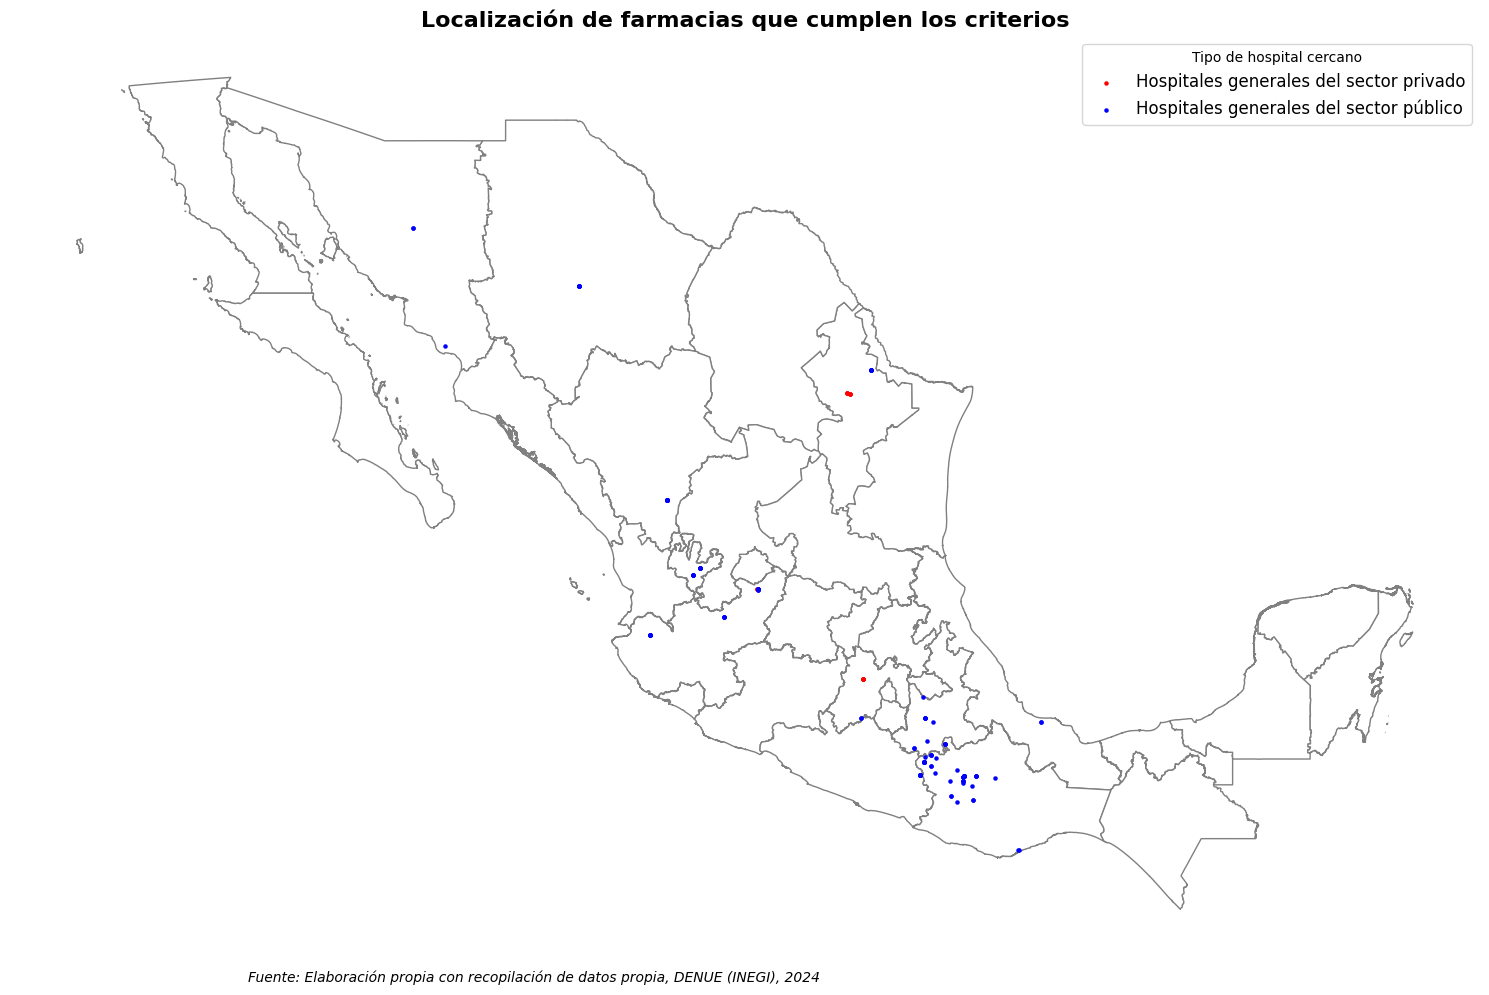

In [314]:
fig, ax = plt.subplots(figsize=(15,10))
mexico.plot(ax=ax, color='white', edgecolor='gray')

tipo_hospitales = vis_final['categoria'].unique()
colors = ['red', 'blue', 'green', 'orange'][:len(tipo_hospitales)]

for categoria, color in zip(tipo_hospitales, colors):
    subset = vis_final[vis_final['categoria'] == categoria]
    subset.plot(ax=ax, color=color, marker='o', markersize=5, label=categoria)

ax.set_title("Localización de farmacias que cumplen los criterios", fontsize=16, fontweight='bold')
plt.figtext(0.55, 0.01, "Fuente: Elaboración propia con recopilación de datos propia, DENUE (INEGI), 2024", 
            ha="right", fontsize=10, style='italic')
ax.set_axis_off()
plt.legend(fontsize=12, title="Tipo de hospital cercano")
plt.tight_layout()
plt.show()